<a href="https://colab.research.google.com/github/joshuawiser/joshuawiser/blob/main/Copy_of_Yet_another_copy_of_module_5_wiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project
## Recognizing street signs for a German self driving car company

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

^C
^C
Unzipping files...
unzip:  cannot find or open /content/training1.zip, /content/training1.zip.zip or /content/training1.zip.ZIP.
unzip:  cannot find or open /content/training2.zip, /content/training2.zip.zip or /content/training2.zip.ZIP.
replace holdout/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace mini_holdout/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Merging training data...
mkdir: cannot create directory ‘/content/training’: File exists
mv: cannot move '/content/training1/00000' to '/content/training/00000': Directory not empty
mv: cannot move '/content/training1/00001' to '/content/training/00001': Directory not empty
mv: cannot move '/content/training1/00002' to '/content/training/00002': Directory not empty
mv: cannot move '/content/training1/00003' to '/content/training/00003': Directory not empty
mv: cannot move '/content/training1/00004' to '/content/training/00004': Directory not empty
mv: cannot move '/content/training1/00005' to '/content/training/0

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

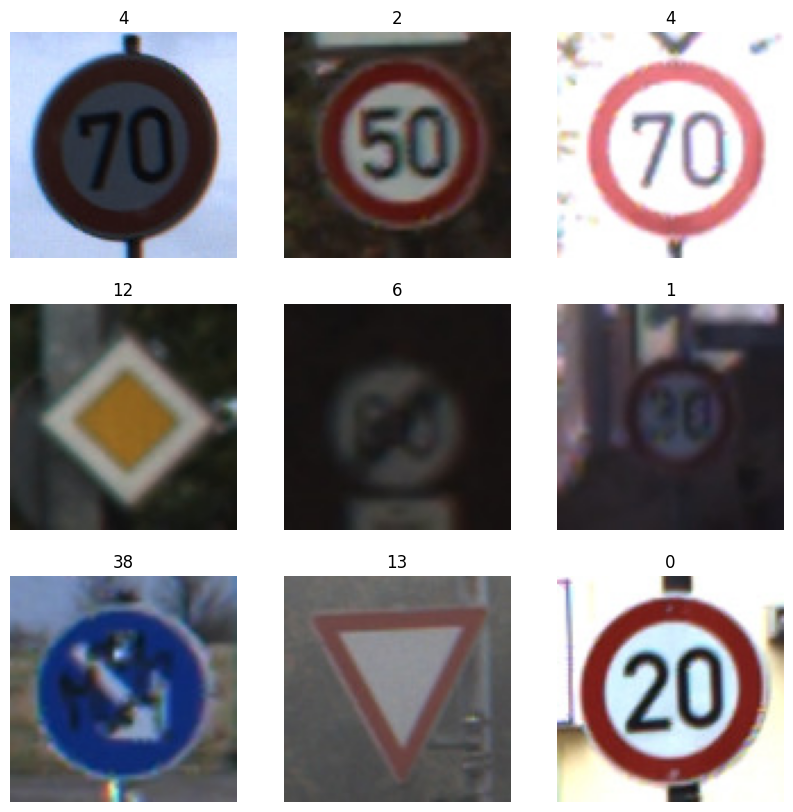

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# VGG - 16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False  # Freeze the layers for the initial training


model = Sequential([
    base_model,
    Flatten(),  # Use Flatten for VGG-16 instead of GlobalAveragePooling2D
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate for better regularization
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(43, activation='softmax')  # Output layer for 43 classes
])

# Compile with a higher initial learning rate
initial_lr = 1e-3
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Exponential decay for the learning rate scheduler
def exp_decay(epoch):
    decay_rate = 0.9  # factor
    return initial_lr * (decay_rate ** epoch)

lr_scheduler = LearningRateScheduler(exp_decay)

# Data augmentation with a slightly reduced validation split (was .2)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          # Rotation for augmentation
    width_shift_range=0.15,     # Width shift
    height_shift_range=0.15,    # Height shift
    zoom_range=0.15,            # Zoom augmentation
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    validation_split=0.15       # Reduced validation split
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    subset="training",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    subset="validation"
)

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Initial training with frozen layers
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

# Fine-tuning: unfreeze top layers of VGG-16 after initial training
base_model.trainable = True
for layer in base_model.layers[:-15]:  # Unfreeze the last 15 layers for fine-tuning
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Found 33337 images belonging to 43 classes.
Found 5872 images belonging to 43 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 118s 110ms/step - accuracy: 0.4382 - loss: 1.9746 - val_accuracy: 0.5778 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 2/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 112s 106ms/step - accuracy: 0.6825 - loss: 1.0113 - val_accuracy: 0.6313 - val_loss: 1.1915 - learning_rate: 9.0000e-04
Epoch 3/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 112s 107ms/step - accuracy: 0.7264 - loss: 0.8542 - val_accuracy: 0.6540 - val_loss: 1.1861 - learning_rate: 8.1000e-04
Epoch 4/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 113s 107ms/step - accuracy: 0.7504 - loss: 0.7643 - val_accuracy: 0.6931 - val_loss: 1.0370 - learning_rate: 7.2900e-04
Epoch 5/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 111s 106ms/step - accuracy: 0.7712 - loss: 0.6984 - val_accuracy: 0.6929 - val_loss: 1.0953 - learning_rate: 6.5610e-04
Epoch 6/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 112s 106ms/step - accuracy: 0.7837 - loss: 0.6756 - val_accuracy: 0.6974 - val_loss: 0.9985 - learning_rate: 5.9049e-04
Epoch 7/20
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1

Found 201 images belonging to 1 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Mini Holdout Set Overall Accuracy: 100.00%
Classification Report:
                                precision    recall  f1-score   support

                     Speed_30       1.00      1.00      1.00        11
                     Speed_50       1.00      1.00      1.00         8
                     Speed_60       1.00      1.00      1.00        10
                     Speed_70       1.00      1.00      1.00         9
                     Speed_80       1.00      1.00      1.00         5
             Speed_Limit_Ends       1.00      1.00      1.00         3
                    Speed_100       1.00      1.00      1.00         8
                    Speed_120       1.00      1.00      1.00         6
        Overtaking_Prohibited       1.00      1.00      1.00        10
Overtakeing_Prohibited_Trucks       1.00      1.00      1.00        12
              Crossroad_Ahead       1.00      1.00      1.00         8
 

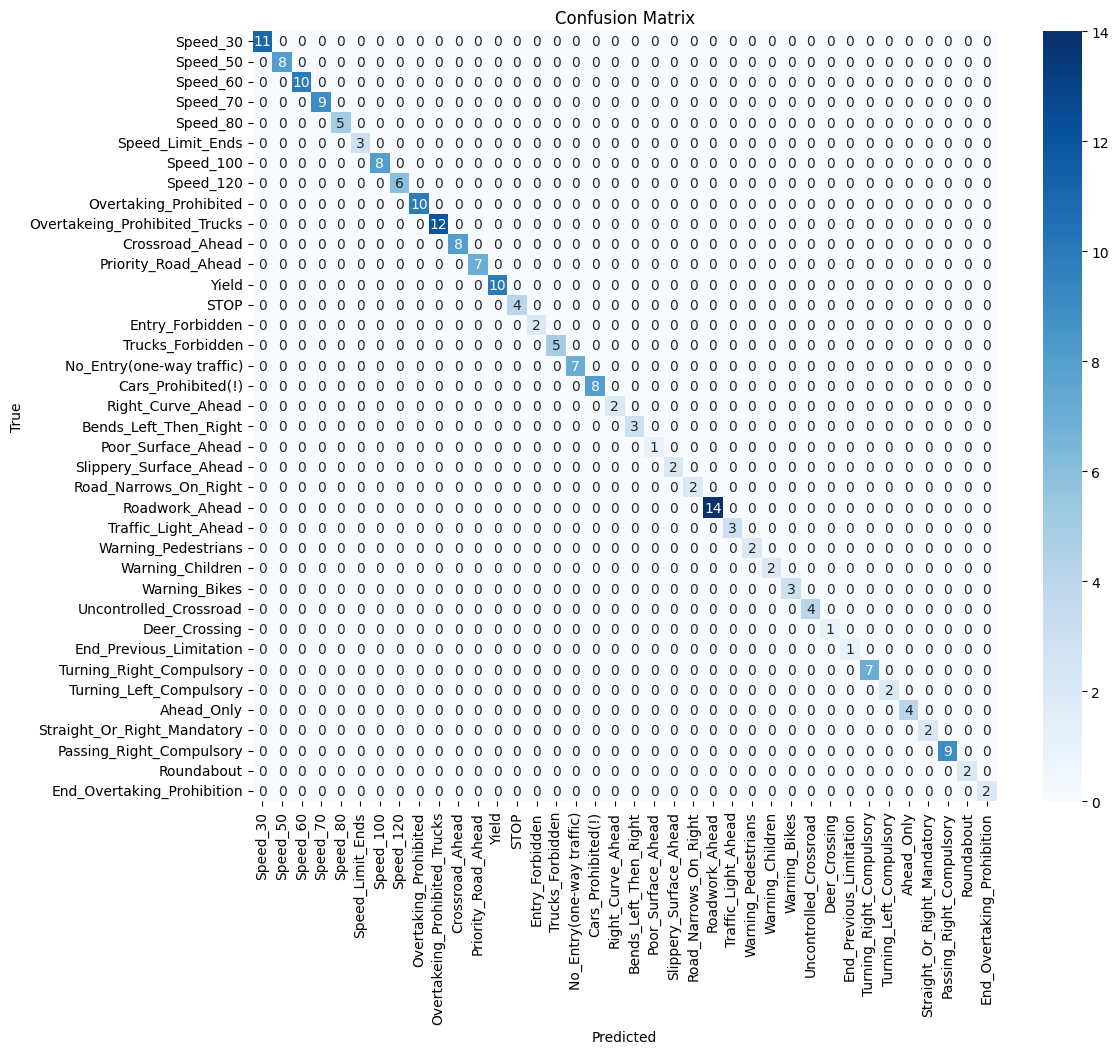

In [ ]:
# Define test directory and image size for evaluation
test_dir = '/content'  # Root directory containing mini_holdout
image_size = (100, 100)

# Evaluate on Mini Holdout Dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],  # Folder containing the mini holdout images
    target_size=image_size,
    class_mode='sparse',
    shuffle=False
)

# Predict on mini holdout dataset
probabilities = model.predict(test_generator)
predictions = np.argmax(probabilities, axis=1)

# Load ground truth answers for mini holdout dataset
holdout_answers = pd.read_csv('/content/mini_holdout_answers.csv')
filenames = [f.split('/')[-1] for f in test_generator.filenames]
predictions_df = pd.DataFrame({'Filename': filenames, 'Prediction': predictions})
merged_df = holdout_answers.merge(predictions_df, on='Filename')

# Calculate overall accuracy
overall_accuracy = np.mean(merged_df['ClassId'] == merged_df['Prediction'])
print(f"Mini Holdout Set Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Detailed classification report
true_labels = merged_df['ClassId']
predicted_labels = merged_df['Prediction']

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report and confusion matrix
unique_classes = sorted(true_labels.unique())  # Define classes from true labels
filtered_target_names = [target_names[i] for i in unique_classes]

report = classification_report(true_labels, predicted_labels, target_names=filtered_target_names)
print("Classification Report:\n", report)

# Confusion matrix visualization
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=filtered_target_names, yticklabels=filtered_target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

Found 12630 images belonging to 1 classes.
 11/395 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


In [ ]:
probabilities

array([[1.1166431e-06, 1.9837371e-06, 8.1329489e-08, ..., 5.1360633e-08,
        4.0739174e-08, 5.3070668e-09],
       [3.7021175e-06, 9.9999285e-01, 1.0688700e-06, ..., 7.3532309e-09,
        8.9588337e-09, 3.2881668e-09],
       [1.0093067e-08, 7.1918720e-08, 1.0617485e-06, ..., 1.1815220e-07,
        6.1265233e-08, 1.9230102e-07],
       ...,
       [1.2976571e-04, 6.4508658e-06, 1.2302633e-04, ..., 2.6191483e-06,
        9.6746765e-02, 2.6512593e-01],
       [7.6568938e-09, 7.1012946e-06, 1.8388324e-07, ..., 2.4671010e-09,
        3.9642307e-09, 4.3209312e-08],
       [1.0289597e-08, 6.4848904e-09, 8.2787679e-08, ..., 3.3847730e-08,
        3.9126199e-08, 8.5363649e-07]], dtype=float32)

In [ ]:
final_df = pd.DataFrame({'predictions': predictions})

In [ ]:
final_df.to_csv('predictions.csv')